# OpenAI Function Calling In LangChain

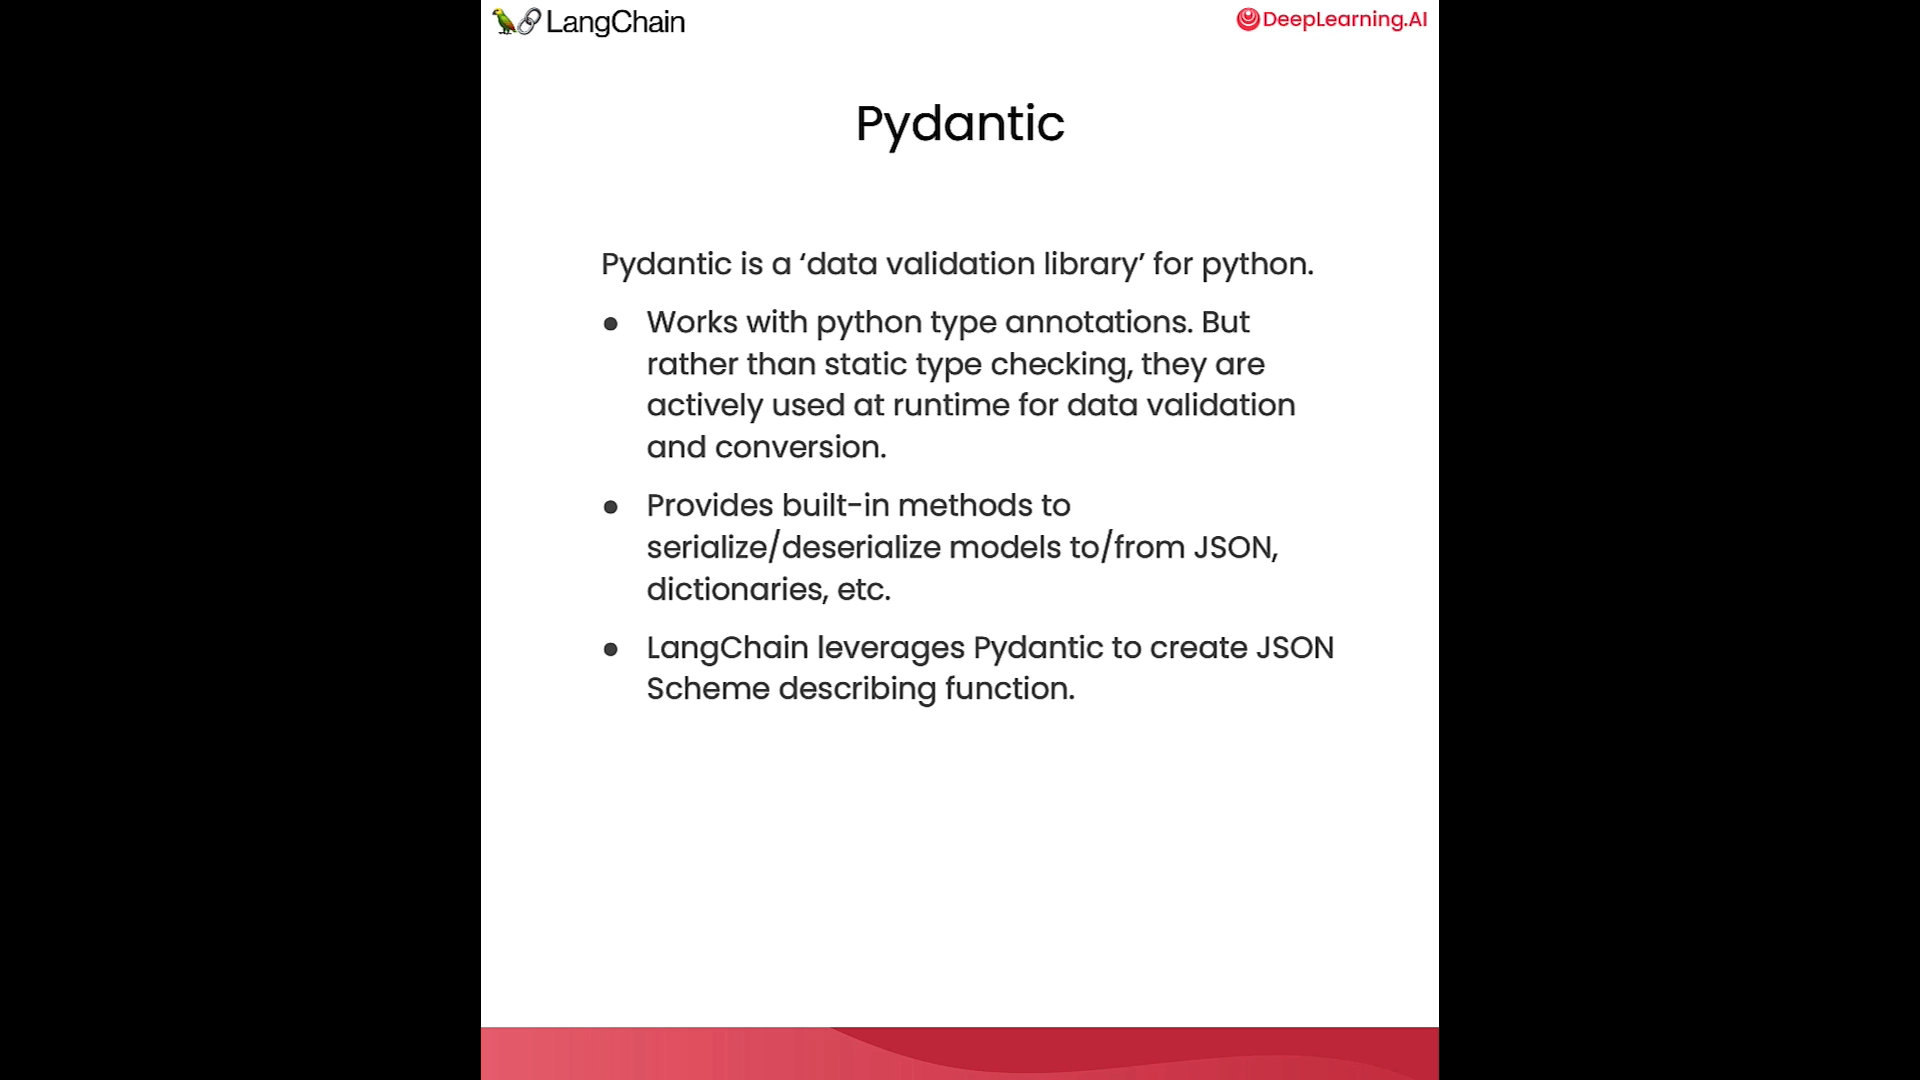

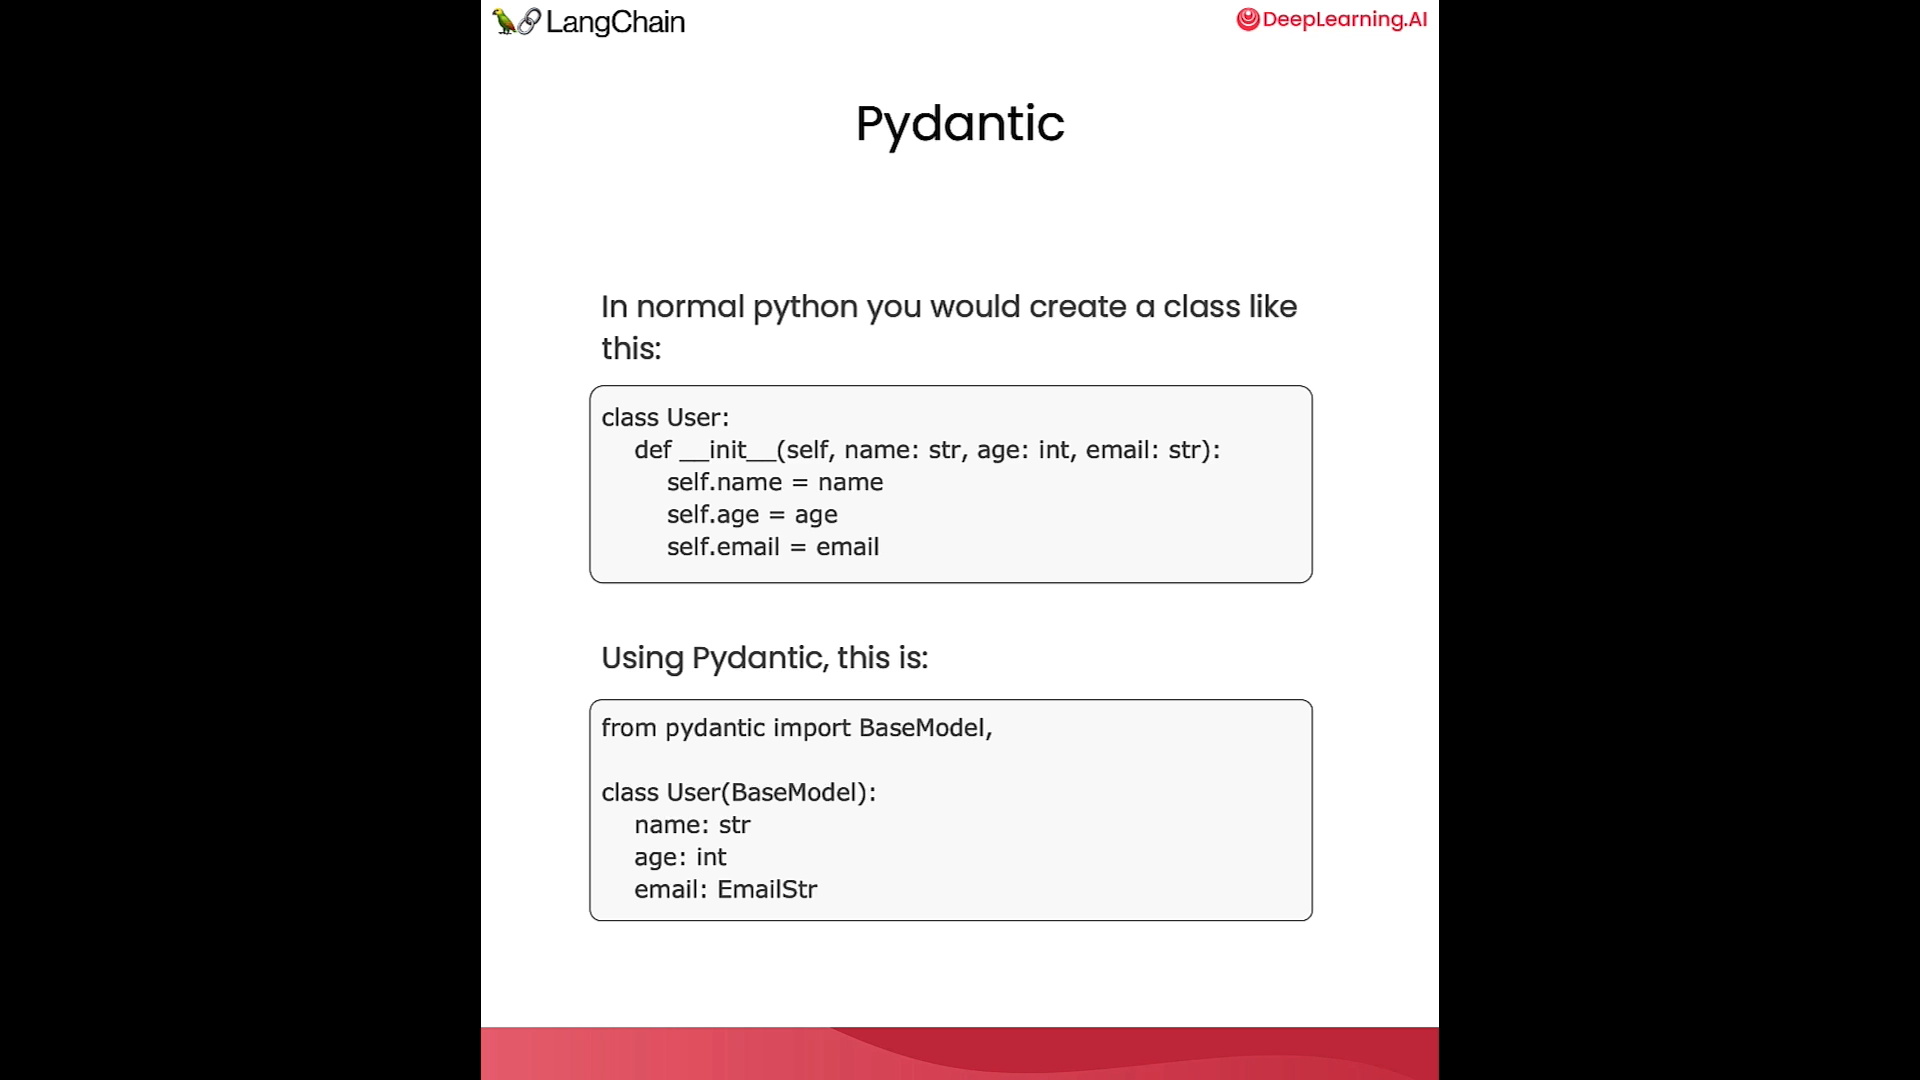

We will use this class to create OPEN AI Functions 

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from typing import List
from pydantic import BaseModel, Field

## Pydantic Syntax

Pydantic data classes are a blend of Python's data classes with the validation power of Pydantic. 

They offer a concise way to define data structures while ensuring that the data adheres to specified types and constraints.

In standard python you would create a class like this:

In [3]:
class User:
    def __init__(self, name: str, age: int, email: str):
        self.name = name
        self.age = age
        self.email = email

In [4]:
foo = User(name="Joe",age=32, email="joe@gmail.com")

In [5]:
foo.name

'Joe'

In [8]:
foo = User(name="Joe",age="bar", email="joe@gmail.com") ## Here age is Int . But with normal class .It is also accepting String
## To avoid all this we can use pydantic

In [9]:
foo.age

'bar'

In [10]:
class pUser(BaseModel):
    name: str
    age: int
    email: str

In [11]:
foo_p = pUser(name="Jane", age=32, email="jane@gmail.com")

In [12]:
foo_p.name

'Jane'

**Note**: The next cell is expected to fail.

In [13]:
foo_p = pUser(name="Jane", age="bar", email="jane@gmail.com") ## here age is int . But if we pass str .It will fail .Because str is not acceeptable

ValidationError: 1 validation error for pUser
age
  value is not a valid integer (type=type_error.integer)

In [14]:
class Class(BaseModel):
    students: List[pUser]

In [15]:
obj = Class(
    students=[pUser(name="Jane", age=32, email="jane@gmail.com")]
)

In [16]:
obj

Class(students=[pUser(name='Jane', age=32, email='jane@gmail.com')])

## Pydantic to OpenAI function definition


In [17]:
class WeatherSearch(BaseModel): 
    ## To setup description we can use Field
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str = Field(description="airport code to get weather for")

In [18]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function

In [19]:
## Converts pydantic object to openai function
weather_function = convert_pydantic_to_openai_function(WeatherSearch)

In [20]:
weather_function

{'name': 'WeatherSearch',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'title': 'WeatherSearch',
  'description': 'Call this with an airport code to get the weather at that airport',
  'type': 'object',
  'properties': {'airport_code': {'title': 'Airport Code',
    'description': 'airport code to get weather for',
    'type': 'string'}},
  'required': ['airport_code']}}

In [21]:
class WeatherSearch1(BaseModel): ## Here we are not specifing what does this function do .So when you convert it gives error
    airport_code: str = Field(description="airport code to get weather for")

**Note**: The next cell is expected to generate an error.

In [22]:
convert_pydantic_to_openai_function(WeatherSearch1)

KeyError: 'description'

In [23]:
class WeatherSearch2(BaseModel):
    """Call this with an airport code to get the weather at that airport"""
    airport_code: str

In [24]:
convert_pydantic_to_openai_function(WeatherSearch2) ##This will also work

{'name': 'WeatherSearch2',
 'description': 'Call this with an airport code to get the weather at that airport',
 'parameters': {'title': 'WeatherSearch2',
  'description': 'Call this with an airport code to get the weather at that airport',
  'type': 'object',
  'properties': {'airport_code': {'title': 'Airport Code', 'type': 'string'}},
  'required': ['airport_code']}}

In [25]:
from langchain.chat_models import ChatOpenAI

In [26]:
model = ChatOpenAI()

In [27]:
model.invoke("what is the weather in SF today?", functions=[weather_function])

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

In [28]:
model_with_function = model.bind(functions=[weather_function])

In [29]:
model_with_function.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

## Forcing it to use a function

We can force the model to use a function

In [30]:
model_with_forced_function = model.bind(functions=[weather_function], function_call={"name":"WeatherSearch"})

In [31]:
model_with_forced_function.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

In [32]:
model_with_forced_function.invoke("hi!")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

## Using in a chain

We can use this model bound to function in a chain as we normally would

In [33]:
from langchain.prompts import ChatPromptTemplate

In [34]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant"),
    ("user", "{input}")
])

In [35]:
chain = prompt | model_with_function

In [36]:
chain.invoke({"input": "what is the weather in sf?"})

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

## Using multiple functions

Even better, we can pass a set of function and let the LLM decide which to use based on the question context.

In [37]:
class ArtistSearch(BaseModel):
    """Call this to get the names of songs by a particular artist"""
    artist_name: str = Field(description="name of artist to look up")
    n: int = Field(description="number of results")

In [38]:
functions = [
    convert_pydantic_to_openai_function(WeatherSearch),
    convert_pydantic_to_openai_function(ArtistSearch),
]

In [39]:
model_with_functions = model.bind(functions=functions)

In [40]:
model_with_functions.invoke("what is the weather in sf?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'WeatherSearch', 'arguments': '{\n  "airport_code": "SFO"\n}'}})

In [41]:
model_with_functions.invoke("what are three songs by taylor swift?")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'ArtistSearch', 'arguments': '{\n"artist_name": "taylor swift",\n"n": 3\n}'}})

In [42]:
model_with_functions.invoke("hi!")

AIMessage(content='Hello! How can I assist you today?')